In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from typing import Tuple
from price_impact.modelling.backtest_analysis import BacktestResults, BacktestSettings
from price_impact.modelling.Futures import FutureContract, Spot
from price_impact.execution.discrete_execution.impact_models import PropagatorImpactModel
from price_impact.execution.discrete_execution.utils import resample_lambdas, example_delta_lambdas, get_std
from price_impact import data_dir, regression_path

from dateutil.relativedelta import relativedelta
import datetime as dt
from pathlib import Path
np.random.seed(0)

PLOT_FOLDER = Path("./plots")
bin_path = data_dir / 'synthetic'/'bins'

plt.style.use('bmh')

In [9]:
spot = Spot('NQ') # nasdaq
date = '2021-01-01' # which backtest window to get calibrated values from


# note, aestheticness of optimal output is very sensitive to solver parameters such as tol. 
# Can adjust as needed 
tol = 1e-5

delta=0.7 
  avg lambda = 381.38
trading_hours=23.0
stdev=0.00016
total_volume=0.1


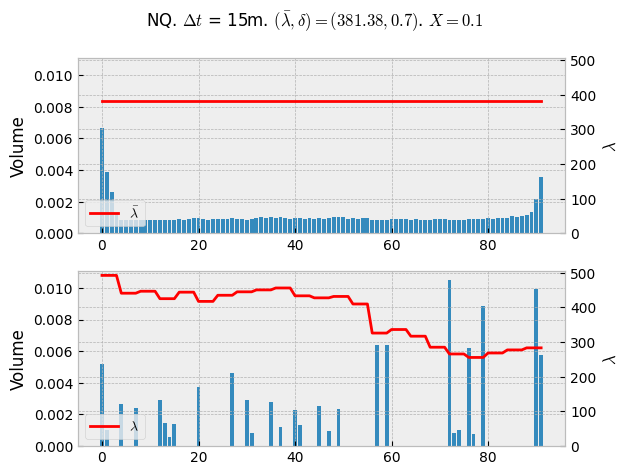

In [14]:
train_months = 6
test_months = 3
smoothing = 'sma20'
half_life_s = 60*60

backtest_settings = BacktestSettings(
        train_len=train_months,
        test_len=test_months,
        bin_freq='10s',
        forecast_horizon_s=10,
        smoothing_str=smoothing,
        decay=half_life_s)


future = FutureContract.from_spot(spot)
freq_m = 15

delta, lambdas = example_delta_lambdas(future, backtest_settings, date=date)
print(f"{delta=} \n  avg lambda = {lambdas.mean():.2f}")

num_bins = len(lambdas)
trading_hours = num_bins//(60/freq_m)
print(f"{trading_hours=}")
do_bounds = True
spread_bps = 0
stdev = 0.0002
stdev = get_std(spot=spot, test_start_date=date, train_len=train_months)
print(f"{stdev=:.5f}")
options = {'maxiter': 1e4}

method = 'SLSQP'
total_volume = 0.1
print(f"{total_volume=}")


const_pim = PropagatorImpactModel(half_life_s=half_life_s, delta=delta,
                                  trading_hours=trading_hours, freq_m=freq_m, stdev=stdev,
                                  lambdas=lambdas.mean())

twap = np.ones(shape=num_bins)*total_volume/num_bins
twap_cost_placeholder = const_pim.func_to_optimise(twap)
divisor = twap_cost_placeholder*100

const_res = const_pim.get_optimal_volume(spread_bps=spread_bps, total_volume=total_volume,
                                         do_bounds=do_bounds, tol=tol, options=options,
                                         method=method, divisor=divisor)

var_pim = PropagatorImpactModel(half_life_s=half_life_s, delta=delta,
                                trading_hours=trading_hours, freq_m=freq_m, stdev=stdev,
                                lambdas=lambdas)

var_res = var_pim.get_optimal_volume(spread_bps=spread_bps, total_volume=total_volume,
                                     do_bounds=do_bounds, tol=tol, options=options,
                                     method=method, divisor=divisor)

fig, axs = plt.subplots(2, 1)
idx = np.linspace(0, len(const_res.x)-1, len(const_res.x))

axs[0].bar(idx, const_res.x)
ax1 = axs[0].twinx()
ax1.plot(idx, np.full_like(idx, fill_value=lambdas.mean()), label=r"$\bar{\lambda}$", color='r')
ax1.set_ylim(bottom=0)
ax1.legend(loc=3)

axs[1].bar(idx, var_res.x)
ax2 = axs[1].twinx()
ax2.plot(idx, lambdas, label=r"$\lambda$", color='r')
ax2.set_ylim(bottom=0)
ax2.legend(loc=3)


axs[0].set_ylabel("Volume")
axs[1].set_ylabel("Volume")
ax1.set_ylabel(r"$\lambda$")
ax2.set_ylabel(r"$\lambda$")

ymax = max([axs[i].get_ylim()[1] for i in range(2)])
[axs[i].set_ylim(top=ymax) for i in range(2)]

ymax = max([ax.get_ylim()[1] for ax in [ax1, ax2]])
[ax.set_ylim(top=ymax) for ax in [ax1, ax2]]
title = fr"{spot}. $ \Delta t $ = {freq_m}m. $ ( \bar{{\lambda}} , \delta ) = ({lambdas.mean():.2f} , {delta}) $. "
title += fr"$X={total_volume}$"
fig.suptitle(title)
fig.tight_layout()
